# DimensionAD Dashboard Project

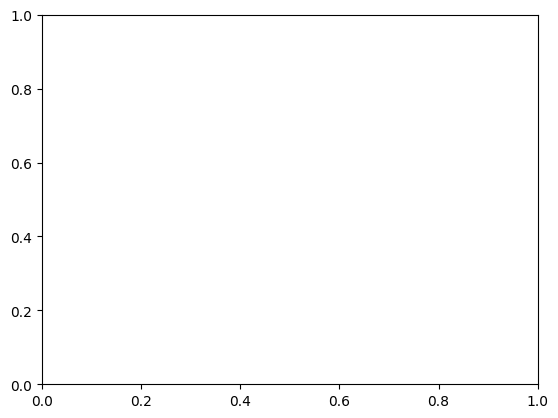

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import ipywidgets as widgets
from ipywidgets import interact, fixed
import itertools
import os.path
import datetime

ax = plt.gca()
PLOT_NO = 131

#moving averages go backwards
#jupyter notebook macros directives

#label lines in multiplots
#x-axis dates need to be labelled better
#plot cumulative returns instead of normal returns

#add toggles for multiplots, to show/hide particular lines
#slider to vary dates

In [2]:
# plots a graph with given parameters, x, y data
def plotData(graphType, x, y, gLabel, isSubplot=True, width=-1):
    global PLOT_NO
    try:
        if isSubplot:
            plt.subplot(PLOT_NO)
            PLOT_NO += 1
        plot_func = getattr(plt, graphType)
        if width == -1:
            plot_func(x, y, label=gLabel)
        else:
            plot_func(x, y, label=gLabel, width=width)
        if not gLabel == "":
            plt.legend(loc="upper left")
    except AttributeError:
        if graphType == 'N/A':
            pass
        else:
            raise ValueError('Unsupported graph type ' + graphType + '.')

In [3]:
# adds labels to current graph and outputs the final result
def presentGraph(xLabel, yLabel, title, isShow):
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    if isShow:
        plt.show()

In [4]:
def resetPlotNo():
    global PLOT_NO
    PLOT_NO = 131

In [5]:
# gets dataframe and accounts for missing headings
def getDataframe(fileFormat, filepath):

    if not (os.path.isfile(filepath)):
        raise ValueError('File does not exist')

    # if headings do not exist, get headings and set names equal to those headings
    if checkHeadings(filepath):
        headings = getHeadings(fileFormat)
        df = pd.read_csv(filepath, names = headings)
    # if headings already exist, we can just read the csv file and pandas will assume top row is headings
    else:
        df = pd.read_csv(filepath)

    return df

In [6]:
# returns true if headings do not exist (i.e. need to add headings)
# and returns false if the csv file already has headings
def checkHeadings(filepath):
    # gets the top row of the CSV
    top = pd.read_csv(filepath, header = None).head(1).values.tolist()[0]

    # loop through the elements of the top row
    for element in top:
        # if each and every element is a string, then conclude that headings exist
        if isinstance(element, str):
            continue
        # if any of the cells is not a string, e.g. is a number, then conclude that headings do not exist
        else:
            return True

    return False

In [7]:
# returns a list of correct headings
def getHeadings(fileFormat):
    # currently the headings for CSI data is known,
    # to work with more types of data, we can simply add additional if statements here
    # headings must be known
    if fileFormat == 'CSI':
        return ['Date', 'Source', 'Source-ID', 'Open', 'High', 'Low', 'AdjustedClose', 'Close', 'Volume', 'Contract']
    else:
        raise ValueError('This is CSV data is currently unavailable, only CSI data is supported')

In [8]:
# extracts a title from a filepath
def getFilename(filepath):
    # turn the path into an array split at every '/'
    splitPath = filepath.split('/')
    # get just the filename from whole path
    fileName = splitPath[len(splitPath)-1]
    # remove file extension
    return fileName.split('.')[0]

In [9]:
def describe_helper(series):

    statStr = ""
    
    desc = series.describe() # series of stats
    splits = str(desc).split() # string array of labels and stats, e.g. ["mean", 2.12, ..]
    
    for i in range(len(desc)):
        x = (i*2)+1 # relationship between splits and desc index is 2n+1
        splits[x] = str(round(desc[i]))
        
    for j in range (0, len(splits)-1, 2):
        statStr += (splits[j] + ": " + splits[j+1] + "    ")
        
    return statStr

In [10]:
# calculates the exponentially weighted moving average for a dataset and given half life
def calcEWMA(data, halflife):
    weights = [(1/2)**(x/halflife) for x in range(len(data), 0, -1)]
    out = []
    for i in range(1, len(data)+1):
        m = wmean(data[:i], weights[:i])
        out.append(m)
    return out

In [11]:
# compute the weighted mean of data
def wmean(data, weights):
    # compute weighted mean of data.
    assert len(data) == len(weights)
    numer = [data[i] * weights[i] for i in range(len(data))]
    return (sum(numer)/sum(weights))

In [12]:
# calculates the simple moving average for a dataset and given window size
def calcSMA(data, winSize):
    # iteratively compute simple moving average over window of data.
    m = mean(data[:winSize])
    out = [float('nan')] * (winSize-1) + [m]
    for i in range(winSize, len(data)):
        m += (data[i] - data[i-winSize]) / winSize
        out.append(m)
    return out

In [13]:
# compute mean of data
def mean(data):
    return sum(data) / len(data)

In [14]:
# given an array, return the cumulative version
def cumArray(arr, startIndex):
    for i in range (startIndex, len(arr)):
        arr[i] = arr[i] + arr[i-1]
    return arr

In [15]:
def redrawGraph(endYear):
    plotTimeSeries(fileFormat, filepath, dependentVar, startYear, endYear, plotType)

## The following functions plot the different types of graphs

In [16]:
# plots a graph of a given variable against date
def plotTimeSeries(fileFormat, filepath, dependentVar, startYear, endYear, plotType):

    startDate = startYear + "-01-01"
    endDate = endYear + "-01-01"
    
    df = getDataframe(fileFormat, filepath)
    dfBetween = df[(df['Date'] >= startDate) & (df['Date'] <= endDate)] # filter to include rows only within date range

    if not dependentVar in df.columns:
        raise ValueError('This field (' + dependentVar + ') does not exist')

    # get dates and the dependent variable data from the data frame
    # and flatten arrays with itertools
    dates = list(itertools.chain.from_iterable(dfBetween[['Date']].values.tolist()))
    dependent = list(itertools.chain.from_iterable(dfBetween[[dependentVar]].values.tolist()))
    
    # dates array for xticks - this does NOT work
    axisDates = []
    for i in range (int(endYear)-int(startYear)):
        axisDates.append(str(int(startYear)+i) + "-01-01")

    plt_1 = plt.figure(figsize=(10,4.5))
    title = getFilename(filepath)
    
    if plotType == 'multiplot':
        plotData('plot', dates, dependent, "")
        plt.xticks(axisDates)
        presentGraph("Date", dependentVar, title, False)
        plotData('plot', dates, calcSMA(dependent, int(len(dependent)*0.03)), "")
        plt.xticks(axisDates)
        presentGraph("Date", dependentVar, 'Simple moving average', False)
        plotData('plot', dates, calcEWMA(dependent, 32), "")
        plt.xticks(axisDates)
        presentGraph("Date", dependentVar, 'Exponential moving average', True)
        resetPlotNo()
        
    elif plotType == 'multiwindow':
        plotData('plot', dates, dependent, "Time Series", False)
        plotData('plot', dates, calcSMA(dependent, int(len(dependent)*0.05)), "Small window SMA", False)
        plotData('plot', dates, calcSMA(dependent, int(len(dependent)*0.2)), "Large window SMA", False)
        plt.xticks(axisDates)
        presentGraph("Date", dependentVar, title, True)
        resetPlotNo()
        
    else:
        plotData('plot', dates, dependent, "Time Series")
        
        # ATTEMPT 1 at slider widget
        ## on_changed takes a function, however, this function will need parameters, so this doesn't work
        plt.subplots_adjust(bottom=0.25)
        ax_slider = plt.axes([0.1, 0.1, 0.8, 0.05], facecolor=teal)
        slider = Slider(ax_slider, "Year", valmin=startYear+1, valmax=endYear, valinit=startYear+1, valstep=1)
        slider.on_changed(redrawGraph)
        
        presentGraph("Date", dependentVar, title, True)
            
    # add some stats to the figure or simply just print the stats
    #plt.text(-0.1, -0.1, describe_helper(pd.Series(dependent)), transform=ax.transAxes, ha='left', va='top')
    print(describe_helper(pd.Series(dependent)))

In [17]:
# plots a graph of returns of a given variable (the day to day difference) against date
def plotReturns(fileFormat, filepath, returnsVar):
    
    df = getDataframe(fileFormat, filepath)
    
    # get dates and the differences of the returns data from the data frame
    # and flatten array with itertools
    dates = list(itertools.chain.from_iterable(df[['Date']].values.tolist()))
    returns = list(itertools.chain.from_iterable(df[[returnsVar]].diff().values.tolist())) # uses pandas .diff() method to get differences between days
    
    for i in range (len(returns)):
        if returns[i] < 0:
            returns[i] = returns[i] * -1
    
    cumReturns = cumArray(returns, 2)
    
    title = getFilename(filepath)
    plt_1 = plt.figure(figsize=(12,3.5))
    
    plotData('plot', dates, cumReturns, '')
    presentGraph("Date", (returnsVar + ' returns'), title, True)
    
    # add some stats to the figure or simply just print the stats
    print(describe_helper(pd.Series(returns)))

In [18]:
# plots a graph of arithmetic returns of a given variable against date
def plotAmetricReturns(fileFormat, filepath, returnsVar):

    df = getDataframe(fileFormat, filepath)

    # get dates and the differences of the returns data from the data frame
    # and flatten arrays
    dates = list(itertools.chain.from_iterable(df[['Date']].values.tolist()))
    dependent = list(itertools.chain.from_iterable(df[[returnsVar]].values.tolist()))

    ameticRet = []

    # arithmetic return calculation
    ameticRet.append(float('nan'))
    for i in range (1, len(dependent)):
        ameticRet.append((dependent[i]/dependent[i-1])-1)
    
    for i in range (len(ameticRet)):
        if ameticRet[i] < 0:
            ameticRet[i] = ameticRet[i] * -1

    cumReturns = cumArray(ameticRet, 2)

    title = getFilename(filepath)
    plt_1 = plt.figure(figsize=(12,3.5))
    
    plotData("scatter", dates, cumReturns, '')
    presentGraph("Date", ("Arithmetic " + returnsVar + " returns"), title, True)
    
    # add some stats to the figure or simply just print the stats    
    print(describe_helper(pd.Series(ameticRet)))

In [19]:
# plots a graph of logarithm returns of a given variable against date
def plotLogReturns(fileFormat, filepath, returnsVar):

    df = getDataframe(fileFormat, filepath)

    # get dates and the differences of the returns data from the data frame
    # and flatten arrays
    dates = list(itertools.chain.from_iterable(df[['Date']].values.tolist()))
    dependent = list(itertools.chain.from_iterable(df[[returnsVar]].values.tolist()))

    logRet = []

    # logarithmic return calculation
    logRet.append(float('nan'))
    for i in range (1, len(dependent)):
        logRet.append(np.log(dependent[i]/dependent[i-1]))
        
    for i in range (len(logRet)):
        if logRet[i] < 0:
            logRet[i] = logRet[i] * -1
    
    cumReturns = cumArray(logRet, 2)

    title = getFilename(filepath)
    plt_1 = plt.figure(figsize=(12,3.5))
    
    plotData("scatter", dates, cumReturns, '')
    presentGraph("Date", ("Logarithmic " + returnsVar + " returns"), title, True)
    resetPlotNo()
    
    # add some stats to the figure or simply just print the stats
    print(describe_helper(pd.Series(logRet)))

In [20]:
# plot histogram for a given variable
def histReturns(fileFormat, filepath, returnsVar, startDate, endDate):

    # number of years within range
    years = int(endDate.split('-')[0]) - int(startDate.split('-')[0])
    barWidth = 0.4 + ((years-2) * 0.1)
    if barWidth > 1.0:
        barWidth = 1.0

    df = getDataframe(fileFormat, filepath) # whole dataframe
    dfBetween = df[(df['Date'] >= startDate) & (df['Date'] <= endDate)] # filter to include rows only within date range
    returns = list(itertools.chain.from_iterable(dfBetween[[returnsVar]].diff().values.tolist())) # get the column required and flatten array with itertools

    # create an array of frequencies, and an array of edges, the number of bins should be the number of data points divided by a constant
    freq, edges = np.histogram(returns[1:], bins=(len(returns)//30) )
    # find the mid points of each bin
    midWith = (edges[1:]+edges[:-1])/2

    # plot histogram
    title = ("Histogram: " + returnsVar + " returns for " + getFilename(filepath) + " between " + startDate + " and " + endDate)
    plt_1 = plt.figure(figsize=(10,3.5))
    
    plotData("bar", midWith, freq, '', barWidth)
    presentGraph("Return", "Frequency", title, True)

    # add some stats to the figure or simply just print the stats
    print(describe_helper(pd.Series(midWith)))

# Let's analyse a CSV file

### Enter the following details:

In [21]:
csv = input("Enter the path to the CSV file: ") #e.g. ./data/CSI_HG_1.csv
var = input("Enter the dependent variable to plot: ")

Enter the path to the CSV file: ./data/CSI_HG_1.csv
Enter the dependent variable to plot: Close


## Let's plot the time series for this variable

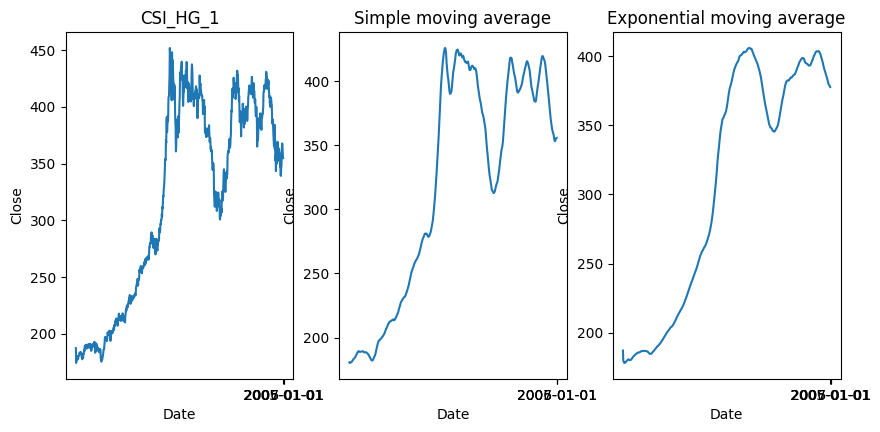

count: 751    mean: 318    std: 89    min: 174    25%: 225    50%: 346    75%: 403    max: 452    dtype:: float64    


In [22]:
plotTimeSeries('CSI', csv, var, '2005', '2008', 'multiplot')

#ATTEMPT 2 at slider widget
#widgets.interact(plotTimeSeries, fileFormat=fixed('CSI'), filepath=fixed(csv), dependentVar=fixed(var), startYear=fixed('2005'), endYear=('2001', '2023', 1), plotType=fixed(''))

## Here we can see the time series of your variable along side the moving averages.

### The simple moving average is calculated using a moving window, of specified size. 
#### Only data within the window is used to calculate the average at each point so that data too far below or above the current point is not considered

### The exponentially weighted moving average is calculated using all past data, however, each piece of data is weighted differently and therefore has different levels of effect on each average calculated. 
#### The weighting is of an exponential nature, i.e. at each point, the current data has most weighting and past values have exponentially decreasing weightings.

## Next, let's look at the moving averages over different time size windows:

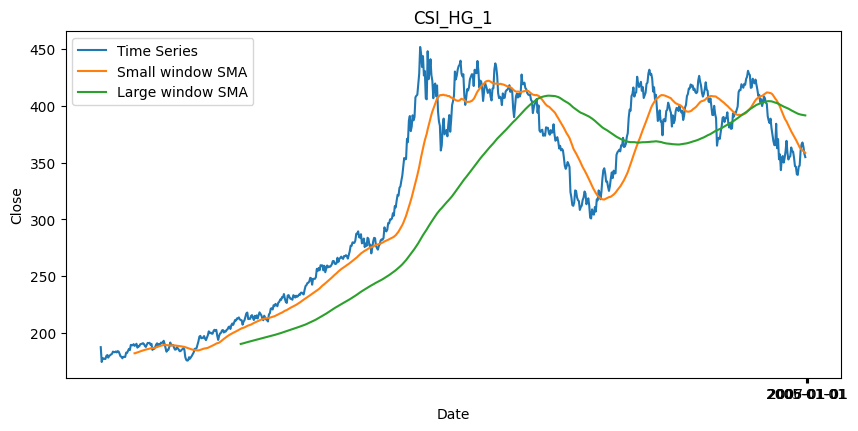

count: 751    mean: 318    std: 89    min: 174    25%: 225    50%: 346    75%: 403    max: 452    dtype:: float64    


In [23]:
plotTimeSeries('CSI', csv, var, '2005', '2008', 'multiwindow')

### We can see that the moving averages look vastly different over different windows

#### The intersections of these lines are often key decision points, e.g. can help decide whether to buy or sell

## Next, let's see the returns for this field:

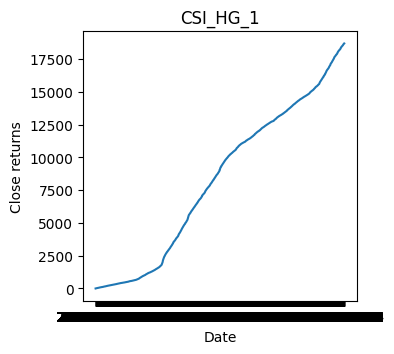

count: 5895    mean: 8253    std: 5899    min: 1    25%: 1551    50%: 9082    75%: 13284    max: 18683    dtype:: float64    


In [24]:
plotReturns('CSI', csv, var)
#plotAmetricReturns('CSI', csv, var)
#plotLogReturns('CSI', csv, var)

##### Here we can see the cumulative returns for this variable.

## Let's now look into the histogram for these returns

### We can use this to analyse anomalies which will represent potential decision points

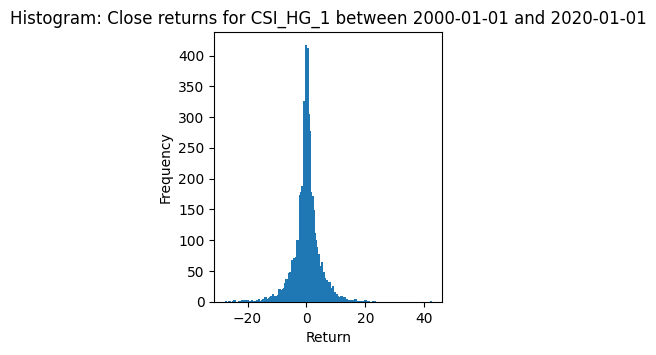

count: 167    mean: 7    std: 20    min: -27    25%: -10    50%: 7    75%: 25    max: 42    dtype:: float64    


In [25]:
histReturns('CSI', csv, var, '2000-01-01', '2020-01-01')

##### We can see that the histogram follows a Gaussian nature

## It's interesting to see how the histogram changes over different time periods,

## Plot a histogram with your own dates:

In [26]:
start = input ("Enter the start date in the format YYYY-MM-DD: ") #e.g. 2012-04-01
end = input ("Enter the end date in the format YYYY-MM-DD: ") #e.g. 2018-04-01

Enter the start date in the format YYYY-MM-DD: 2012-04-01
Enter the end date in the format YYYY-MM-DD: 2018-04-01


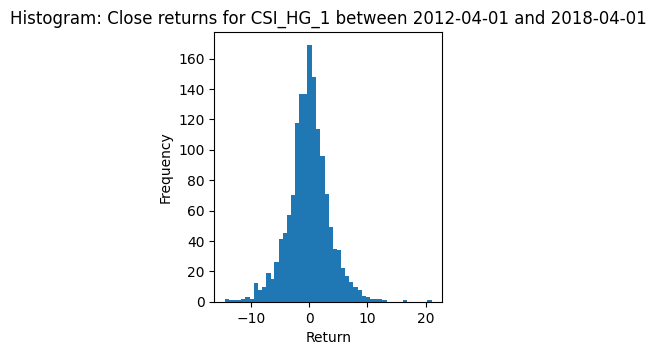

count: 50    mean: 3    std: 10    min: -14    25%: -5    50%: 3    75%: 12    max: 21    dtype:: float64    


In [27]:
histReturns('CSI', csv, var, start, end)